<h1><center><font size="6">Embracing Diversity & Robustness in predicting time to metastatic cancer diagnosis</font></center></h1>

<img src="https://etimg.etb2bimg.com/photo/77373028.cms" width="600"></img>

# ✨ Summary
___________________________________________________________________________________________

- Implementing a **thorough cleaning** proces, as well as treating outliers
- Crafting a few **new features** (age groups, bmi recodes, summary statistics of temperatures over years)
- Performing **Feature Selection** based on Shap values - led to a subset of **13 features** (out of 170 in total)
- **Embracing Diversity** by training 9 different models with minor parameter tunning, mostly decision trees at this point (CatBoost, XGBoost, LightGBM, Random Forest, Gradient Boosting, AdaBoost, ExtraTrees, LightGBM Tweedie, KNeighbors)
- **Increasing Robustness** by ensembling these diverse methods using Ridge Regression
- Overall **Performance**: Local RMSE = **81.823** VS Public Leaderboard = **82.833 / 82.824 / 82.808/ 82.804**.

# 📝 Introduction
___________________________________________________________________________________________

In the first datathon challenge (WiDS 2024 #1) we explored the relationship between socio economic aspects that contribute to health equity. For this next challenge we’re building on that analysis to see how climate patterns impact access to healthcare.

#### Task 
Predict the duration of time it takes for patients to receive metastatic cancer diagnosis, based on *patient characteristics, zip demographics and climate data* (average temperatures).

#### Why is it important?
Metastatic TNBC is considered the most aggressive TNBC and requires urgent and timely treatment. Unnecessary delays in diagnosis and subsequent treatment can have devastating effects in these difficult cancers. Differences in the wait time to get treatment is a good proxy for disparities in healthcare access.

#### Data
- A real-world evidence dataset from Health Verity (HV), one of the largest healthcare data ecosystems in the US, as the main data source for the Datathon. 
- In particular, the HV dataset that we use for this challenge contains health related information of patients who were diagnosed with metastatic triple negative breast cancers in the US. 
- The dataset was then further enriched with zip code level climate data, to explore the relations between health outcomes and climate patterns.
- A detailed description of the data can be found [here](https://www.kaggle.com/competitions/widsdatathon2024-challenge2/data).

# 🛠️ Prerequisites for data analysis
___________________________________________________________________________________________

In [1]:
# Setup
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import RidgeCV

# Define RMSE 
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility
seed = 42

# Display settings
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 200)

In [2]:
# Helpers ------

# Replace missing values
def mixed_imputation(df, group_col):
    for column in df.columns:
        if column != group_col:  # Exclude the group column
            # If the column is numerical, then mean imputation
            if df[column].dtype in [np.dtype('float_'), np.dtype('int_')]:  
                mean_impute = df.groupby(group_col)[column].mean()
                df[column] = df[column].fillna(df[group_col].map(mean_impute))
            
            # If the column is categorical, apply mode imputation
            else :  
                mode_impute = df.groupby(group_col)[column].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
                df[column] = df[column].fillna(df[group_col].map(mode_impute))
            
    return df

In [3]:
# Load data
train_raw = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/train.csv')
test_raw = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/test.csv')
solution_raw = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/solution_template.csv')

print(train_raw.shape)
train_raw.head()

(13173, 152)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9

# 🧹 Data Cleaning & Feature Engineering
___________________________________________________________________________________________

- Drops columns with heavy missingness 
- Fixes duplicates for state at some given zip3 codes
- Recodes male codes to according female correspondent
- Fix outliers with significantly different data at zip level

In [4]:
# Drop columns with heavy missingness
df = train_raw.drop(['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'patient_gender'], axis=1)

# Fix bad zip 
df['patient_state'] = np.where(df['patient_zip3'] == 630, 'MO', np.where(df['patient_zip3'] == 864, 'AZ', df['patient_state']))

# Male codes to female 
df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].replace({
    'C50122':'C50112', 'C50221':'C50211', 'C50421':'C50411', 'C509':'C5091', 'C50922':'C50912'
})

# Recode categories in test data 
test_raw['breast_cancer_diagnosis_code'] = test_raw['breast_cancer_diagnosis_code'].replace({'C5021':'C50219'})

# Population columns
pop_cols = df.loc[:, 'population':'veteran'].columns.to_list()

# Fix outliers 
df.loc[df.patient_id == 441322, pop_cols] = df.loc[df.patient_id == 982003, pop_cols].values
df.loc[df.patient_id == 271422, pop_cols] = df.loc[df.patient_id == 271245, pop_cols].values
df.loc[df.patient_id == 714510, pop_cols] = df.loc[df.patient_id == 636245, pop_cols].values
df.head(2)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.9,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.0,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,35.36,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.4,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.53,0.19,0.05,0.61,3.42,2.78,20.16,16.94,0.43,26.26,6.93,9.71,34.85,36.15,39.41,54.63,65

- Reduces dimensionality of population data based on its original size - unique values are found at zip code
- Imputes missing values with averages values found at zip or state

In [5]:
# Subset population data 
df_pop = df[['patient_zip3', 'patient_state'] + pop_cols].drop_duplicates().sort_values(by='patient_zip3').reset_index(drop=True)

# Impute missing values 
df_pop = mixed_imputation(df=df_pop, group_col='patient_zip3')
df_pop = mixed_imputation(df=df_pop, group_col='patient_state')

print(df_pop.shape)
df_pop.head()

(751, 66)


,patient_zip3,patient_state,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran
0,100,NY,37662.55,29851.69,37.90,8.70,7.81,17.88,20.12,13.02,11.84,9.78,6.60,4.20,48.10,51.90,36.08,10.40,49.31,4.20,3.00,53.72,113117.00,4.41,3.26,4.57,3.19,2.76,5.27,6.73,10.30,8.91,13.80,36.81,50.60,69170.29,24.20,17281.81,1025205.0,2175.51,28.84,9.87,11.37,12.34,34.36,32.05,66.41,43.38,68.81,6.60,18.53,0.02,54.97,13.83,14.02,0.33,0.05,10.01,6.81,21.14,9.11,14.42,8.29,31.40,4.43,2.08
1,101,NY,2746.14,5363.17,41.25,13.85,6.75,10.80,16.95,15.40,8.50,10.85,8.75,8.15,42.55,57.45,46.35,10.40,35.45,7.85,2.85,46.40,113609.50,0.75,1.90,1.35,7.75,1.10,5.35,1.70,4.95,24.80,14.85,35.50,50.35,88910.50,15.85,1389.05,1178137.0,2701.50,31.90,5.00,16.65,7.20,38.35,32.75,71.10,38.35,68.80,2.50,20.86,0.02,85.25,2.55,6.40,0.05,0.00,2.50,3.30,15.65,19.35,4.15,1.15,27.85,5.40,1.20
2,103,NY,37938.00,3697.29,39.87,11.61,13.14,12.73,12.78,13.23,14.12,12.38,6.58,3.44,49.16,50.84,49.43,9.87,35.00,5.70,3.46,55.22,90381.92,4.13,2.24,3.58,2.77,2.46,5.69,8.14,14.72,10.74,19.09,26.47,45.56,42708.58,67.34,13040.62,568177.2,1463.75,34.94,11.95,29.73,24.02,20.72,13.61,34.33,44.51,59.85,5.23,12.96,0.00,67.88,12.19,8.69,0.36,0.03,4.73,6.10,20.46,9.92,10.93,6.44,44.79,4.58,3.28
3,104,NY,58934.16,16936.58,36.22,13.46,13.31,15.06,13.67,12.46,12.61,9.60,6.04,3.75,47.38,52.62,32.32,14.19,47.87,5.62,3.39,45.59,50831.96,6.02,5.56,8.63,5.86,5.42,9.28,12.16,15.19,9.81,11.57,10.51,22.08,27712.36,23.28,21012.52,422924.6,1317.64,41.36,24.51,27.48,25.06,14.24,8.67,22.90,42.65,58.96,10.86,16.05,0.00,24.15,32.52,3.52,0.72,0.12,30.26,8.70,53.74,16.10,25.03,15.92,44.94,7.47,2.52
4,105,NY,10690.73,910.85,43.49,9.90,15.26,10.20,10.85,12.72,15.35,13.88,7.40,4.43,51.06,48.94,53.56,8.99,32.97,4.49,3.21,61.77,147128.20,1.97,0.98,1.50,1.62,2.05,3.91,5.84,9.75,9.39,17.06,45.95,63.01,57872.20,75.79,3801.95,620196.9,2061.17,32.79,7.30,15.13,18.84,28.79,29.95,58.74,43.14,64.75,7.06,17.37,0.00,72.17,7.65,6.96,0.17,0.01,8.13,4.90,15.90,9.39,7.85,3.28,36.81,3.62,3.97


- Reduces dimensionality of climate data at its original size - unique values are found at zip code
- Forward fills the missing values, then backward fills the remaining missings 

In [6]:
# Subset temperatures 
avg_cols = df.columns[df.columns.str.startswith('Average')].tolist()
df_avg = df[['patient_zip3', 'patient_state'] + avg_cols].drop_duplicates().sort_values(by='patient_zip3').reset_index(drop=True)

print(df_avg.shape)
df_avg.head()

(751, 74)


,patient_zip3,patient_state,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
0,100,NY,33.44,30.84,38.45,51.26,60.18,71.91,78.55,71.32,64.49,56.13,41.99,34.79,24.37,26.97,33.92,49.99,61.76,70.54,74.73,71.48,66.73,55.69,41.66,38.25,26.53,20.84,34.33,50.51,66.72,69.80,75.96,75.25,71.07,54.58,48.87,46.33,30.06,35.06,46.52,51.23,60.48,72.47,77.11,77.54,70.08,56.80,45.79,35.42,35.37,37.89,37.02,56.56,59.65,71.17,76.11,72.17,69.26,60.80,42.89,32.62,27.67,37.57,37.87,47.55,65.06,70.23,77.12,77.72,69.82,55.79,42.04,37.18
1,101,NY,33.51,30.81,38.44,51.27,60.14,71.98,78.64,71.34,64.53,56.15,42.03,34.93,24.42,26.97,33.92,NaN,61.76,NaN,74.75,71.51,66.77,55.65,41.72,38.32,26.62,20.97,34.39,50.56,66.82,69.84,76.02,75.35,71.20,54.72,48.96,46.43,30.09,35.16,46.64,51.34,60.55,72.67,77.19,77.67,70.22,56.95,45.83,35.54,35.45,37.99,37.09,56.75,59.79,71.37,76.24,72.29,69.38,60.93,43.01,32.70,27.77,37.69,37.95,47.68,65.17,70.33,77.22,77.83,69.93,55.92,42.16,37.26
2,103,NY,34.01,31.87,38.52,51.63,60.29,71.92,78.43,71.46,64.39,56.21,42.56,35.83,25.57,26.97,34.67,51.46,61.74,70.47,74.70,71.37,66.91,56.54,41.69,38.68,27.28,21.76,35.17,50.75,66.20,69.40,75.87,75.20,70.58,54.21,48.93,47.42,30.88,35.79,46.99,51.55,60.28,71.85,77.05,77.30,70.17,56.61,46.67,36.33,36.01,39.22,37.09,56.44,59.80,70.75,76.06,72.15,69.15,60.29,43.77,32.91,28.04,38.68,38.14,47.99,65.17,70.81,76.90,77.75,69.90,56.45,42.55,37.49
3,104,NY,32.81,31.04,38.55,51.15,60.48,71.39,77.86,71.19,64.10,55.98,41.73,33.68,23.95,26.97,33.92,49.99,61.76,70.54,74.55,71.22,66.44,56.05,41.21,37.70,25.83,19.78,33.79,50.08,65.92,69.54,75.48,74.45,70.01,53.43,48.15,45.55,29.80,34.24,45.55,50.29,59.92,70.84,76.48,76.47,68.93,55.55,45.48,34.50,34.72,37.03,36.50,55.00,58.52,69.56,75.05,71.20,68.33,59.81,41.91,31.91,26.81,36.58,37.22,46.54,64.18,69.41,76.37,76.81,68.91,54.75,41.06,36.54
4,105,NY,29.13,27.78,34.54,48.12,58.59,67.86,75.06,68.19,61.44,53.31,38.38,31.92,20.03,20.35,28.98,46.86,59.60,67.73,72.00,68.59,64.27,54.66,38.04,34.64,22.47,15.58,30.56,47.75,63.83,66.95,72.20,71.25,67.61,50.64,45.29,42.99,26.84,31.00,42.83,47.79,57.43,67.18,73.73,73.14,66.10,52.98,43.58,32.09,31.65,34.71,33.61,52.17,56.50,66.72,71.75,68.49,65.46,57.39,40.07,28.83,23.77,33.59,34.47,43.69,62.71,66.81,73.70,73.99,66.41,52.29,38.51,33.56


In [7]:
# Melt data
df_avg_melt = pd.melt(df_avg, id_vars=['patient_zip3', 'patient_state'])

# Extract month and convert it to datetime
df_avg_melt['month'] = df_avg_melt['variable'].apply(lambda x: x[len(x)-6:])
df_avg_melt['month'] = pd.to_datetime(df_avg_melt['month'], format='%b-%y')

# # Create growth from prior month
df_avg_melt.sort_values(by=['patient_zip3', 'patient_state', 'month'], inplace=True)
# df_avg_melt['MoM_growth'] = df_avg_melt.groupby(['patient_zip3','patient_state'])['value'].pct_change()

# Fill missingness - forward, then backwards for remaining 
df_avg_melt['value'] = df_avg_melt.groupby(['patient_zip3', 'patient_state'])['value'].ffill()
df_avg_melt['value'] = df_avg_melt.groupby(['patient_zip3', 'patient_state'])['value'].bfill()
df_avg_melt.head()

,patient_zip3,patient_state,variable,value,month
0,100,NY,Average of Jan-13,33.44,2013-01-01
751,100,NY,Average of Feb-13,30.84,2013-02-01
1502,100,NY,Average of Mar-13,38.45,2013-03-01
2253,100,NY,Average of Apr-13,51.26,2013-04-01
3004,100,NY,Average of May-13,60.18,2013-05-01


- Creates new features: minimum, maximum and average values for each year 

In [8]:
# Reshape data 
df_avgs = df_avg_melt.drop('month', axis=1).pivot(index=['patient_zip3', 'patient_state'],columns='variable', values='value').reset_index()[['patient_zip3', 'patient_state'] + avg_cols]

# More features 
df_avgs['Min-13'] = df_avgs.loc[:, 'Average of Jan-13':'Average of Dec-13'].min(axis=1)
df_avgs['Max-13'] = df_avgs.loc[:, 'Average of Jan-13':'Average of Dec-13'].max(axis=1)
df_avgs['Avg-13'] = df_avgs.loc[:, 'Average of Jan-13':'Average of Dec-13'].mean(axis=1)

df_avgs['Min-14'] = df_avgs.loc[:, 'Average of Jan-14':'Average of Dec-14'].min(axis=1)
df_avgs['Max-14'] = df_avgs.loc[:, 'Average of Jan-14':'Average of Dec-14'].max(axis=1)
df_avgs['Avg-14'] = df_avgs.loc[:, 'Average of Jan-14':'Average of Dec-14'].mean(axis=1)

df_avgs['Min-15'] = df_avgs.loc[:, 'Average of Jan-15':'Average of Dec-15'].min(axis=1)
df_avgs['Max-15'] = df_avgs.loc[:, 'Average of Jan-15':'Average of Dec-15'].max(axis=1)
df_avgs['Avg-15'] = df_avgs.loc[:, 'Average of Jan-15':'Average of Dec-15'].mean(axis=1)

df_avgs['Min-16'] = df_avgs.loc[:, 'Average of Jan-16':'Average of Dec-16'].min(axis=1)
df_avgs['Max-16'] = df_avgs.loc[:, 'Average of Jan-16':'Average of Dec-16'].max(axis=1)
df_avgs['Avg-16'] = df_avgs.loc[:, 'Average of Jan-16':'Average of Dec-16'].mean(axis=1)

df_avgs['Min-17'] = df_avgs.loc[:, 'Average of Jan-17':'Average of Dec-17'].min(axis=1)
df_avgs['Max-17'] = df_avgs.loc[:, 'Average of Jan-17':'Average of Dec-17'].max(axis=1)
df_avgs['Avg-17'] = df_avgs.loc[:, 'Average of Jan-17':'Average of Dec-17'].mean(axis=1)

df_avgs['Min-18'] = df_avgs.loc[:, 'Average of Jan-18':'Average of Dec-18'].min(axis=1)
df_avgs['Max-18'] = df_avgs.loc[:, 'Average of Jan-18':'Average of Dec-18'].max(axis=1)
df_avgs['Avg-18'] = df_avgs.loc[:, 'Average of Jan-18':'Average of Dec-18'].mean(axis=1)

print(df_avgs.shape)
df_avgs.head()

(751, 92)


variable,patient_zip3,patient_state,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,Min-13,Max-13,Avg-13,Min-14,Max-14,Avg-14,Min-15,Max-15,Avg-15,Min-16,Max-16,Avg-16,Min-17,Max-17,Avg-17,Min-18,Max-18,Avg-18
0,100,NY,33.44,30.84,38.45,51.26,60.18,71.91,78.55,71.32,64.49,56.13,41.99,34.79,24.37,26.97,33.92,49.99,61.76,70.54,74.73,71.48,66.73,55.69,41.66,38.25,26.53,20.84,34.33,50.51,66.72,69.80,75.96,75.25,71.07,54.58,48.87,46.33,30.06,35.06,46.52,51.23,60.48,72.47,77.11,77.54,70.08,56.80,45.79,35.42,35.37,37.89,37.02,56.56,59.65,71.17,76.11,72.17,69.26,60.80,42.89,32.62,27.67,37.57,37.87,47.55,65.06,70.23,77.12,77.72,69.82,55.79,42.04,37.18,30.84,78.55,52.779167,24.37,74.73,51.340833,20.84,75.96,53.399167,30.06,77.54,54.880000,32.62,76.11,54.292500,27.67,77.72,53.801667
1,101,NY,33.51,30.81,38.44,51.27,60.14,71.98,78.64,71.34,64.53,56.15,42.03,34.93,24.42,26.97,33.92,33.92,61.76,61.76,74.75,71.51,66.77,55.65,41.72,38.32,26.62,20.97,34.39,50.56,66.82,69.84,76.02,75.35,71.20,54.72,48.96,46.43,30.09,35.16,46.64,51.34,60.55,72.67,77.19,77.67,70.22,56.95,45.83,35.54,35.45,37.99,37.09,56.75,59.79,71.37,76.24,72.29,69.38,60.93,43.01,32.70,27.77,37.69,37.95,47.68,65.17,70.33,77.22,77.83,69.93,55.92,42.16,37.26,30.81,78.64,52.814167,24.42,74.75,49.289167,20.97,76.02,53.490000,30.09,77.67,54.987500,32.70,76.24,54.415833,27.77,77.83,53.909167
2,103,NY,34.01,31.87,38.52,51.63,60.29,71.92,78.43,71.46,64.39,56.21,42.56,35.83,25.57,26.97,34.67,51.46,61.74,70.47,74.70,71.37,66.91,56.54,41.69,38.68,27.28,21.76,35.17,50.75,66.20,69.40,75.87,75.20,70.58,54.21,48.93,47.42,30.88,35.79,46.99,51.55,60.28,71.85,77.05,77.30,70.17,56.61,46.67,36.33,36.01,39.22,37.09,56.44,59.80,70.75,76.06,72.15,69.15,60.29,43.77,32.91,28.04,38.68,38.14,47.99,65.17,70.81,76.90,77.75,69.90,56.45,42.55,37.49,31.87,78.43,53.093333,25.57,74.70,51.730833,21.76,75.87,53.564167,30.88,77.30,55.122500,32.91,76.06,54.470000,28.04,77.75,54.155833
3,104,NY,32.81,31.04,38.55,51.15,60.48,71.39,77.86,71.19,64.10,55.98,41.73,33.68,23.95,26.97,33.92,49.99,61.76,70.54,74.55,71.22,66.44,56.05,41.21,37.70,25.83,19.78,33.79,50.08,65.92,69.54,75.48,74.45,70.01,53.43,48.15,45.55,29.80,34.24,45.55,50.29,59.92,70.84,76.48,76.47,68.93,55.55,45.48,34.50,34.72,37.03,36.50,55.00,58.52,69.56,75.05,71.20,68.33,59.81,41.91,31.91,26.81,36.58,37.22,46.54,64.18,69.41,76.37,76.81,68.91,54.75,41.06,36.54,31.04,77.86,52.496667,23.95,74.55,51.191667,19.78,75.48,52.667500,29.80,76.48,54.004167,31.91,75.05,53.295000,26.81,76.81,52.931667
4,105,NY,29.13,27.78,34.54,48.12,58.59,67.86,75.06,68.19,61.44,53.31,38.38,31.92,20.03,20.35,28.98,46.86,59.60,67.73,72.00,68.59,64.27,54.66,38.04,34.64,22.47,15.58,30.56,47.75,63.83,66.95,72.20,71.25,67.61,50.64,45.29,42.99,26.84,31.00,42.83,47.79,5

- Recombines the data using the according cleaned subsets
- Imputes `payer_type` using most frequent value at zip or state
- More feature engineering: 
    - Age groups, buckets of equal size: under 29, 30-39, 40-49 ... 90 or more
    - Boolean for missing BMI
    - Recoded BMI in the following buckets: 
        - 0 = Missing
        - 1 = Underweight (BMI < 18.5)
        - 2 = Normal (18.5 <= BMI < 25)
        - 3 = Overweight (25 <= BMI < 30)
        - 4 = Obese (BMI >= 30)

In [9]:
df_full = df.drop(pop_cols + avg_cols, axis=1).merge(
    df_pop, how='left', on=['patient_zip3', 'patient_state']
).merge(
    df_avgs, how='left', on=['patient_zip3', 'patient_state']
)

# Impute payer - most frequent value at zip, then at state
df_full['payer_type'] = mixed_imputation(
    mixed_imputation(
        df_full[['patient_zip3', 'patient_state', 'payer_type']], 
        group_col='patient_zip3'), 
        group_col='patient_state')['payer_type'].values

# Impute race - most frequent value at zip, then at state
df_full['patient_race'] = mixed_imputation(
    mixed_imputation(df_full[['patient_zip3', 'patient_state', 'patient_race']], group_col='patient_zip3'), 
    group_col='patient_state')['patient_race'].values

# Categorize variables
df_full['age_group'] = pd.cut(df_full['patient_age'], right=False, bins=[0, 30, 40, 50, 60, 70, 80, 90, np.inf], labels=[0,1,2,3,4,5,6,7]).astype(int)
df_full['icd_9'] = df_full['breast_cancer_diagnosis_code'].str.startswith('17').astype(int)

# Include bmi info 
df_full['bmi_missing'] = df_full['bmi'].isna().astype(int)
df_full['bmi_recoded'] = np.where(df_full['bmi'].isna(), 0, 
                                  np.where(df_full['bmi'] < 18.5, 1, 
                                          np.where(df_full['bmi'] < 25, 2, 
                                                 np.where(df_full['bmi'] < 30, 3, 4))))
df_full.columns = df_full.columns.str.replace(' ', '_').str.replace('-', '')

print(df_full.shape)
df_full.head()

(13173, 171)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_diagnosis_period,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,Min13,Max13,Avg13,Min14,Max14,Avg14,Min15,Max15,Avg15,Min16,Max16,Avg16,Min17,Max17,Avg17,Min18,Max18,Avg18,age_group,icd_9,bmi_missing,bmi_recoded
0,268700,White,COMMERCIAL,AR,724,South,West South Central,39,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,191,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,37.43,76.75,57.225000,31.67,79.59,56.607500,31.10,81.35,59.133333,35.76,82.78,61.485000,39.80,80.58,60.919167,31.71,81.69,59.132500,1,0,1,0
1,484983,White,COMMERCIAL,IL,629,Midwest,East North Central,55,35.36,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,33,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56

- Transforms the new (testing) data in the same way

In [10]:
# Apply same transformation to new data 
df_test = test_raw.drop(['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'patient_gender'], axis=1)

# Fix bad zip 
df_test['patient_state'] = np.where(df_test['patient_zip3'] == 630, 'MO', 
                                    np.where(df_test['patient_zip3'] == 864, 'AZ', df_test['patient_state']))

# Process averages

# Melt data
df_avg_melt_test = pd.melt(df_test[['patient_zip3', 'patient_state'] + avg_cols].drop_duplicates().sort_values(by='patient_zip3').reset_index(drop=True), id_vars=['patient_zip3', 'patient_state'])

# Extract month and convert it to datetime
df_avg_melt_test['month'] = df_avg_melt_test['variable'].apply(lambda x: x[len(x)-6:])
df_avg_melt_test['month'] = pd.to_datetime(df_avg_melt_test['month'], format='%b-%y')
df_avg_melt_test.sort_values(by=['patient_zip3', 'patient_state', 'month'], inplace=True)

# Fill missingness - forward, then backwards for remaining 
df_avg_melt_test['value'] = df_avg_melt_test.groupby(['patient_zip3', 'patient_state'])['value'].ffill()
df_avg_melt_test['value'] = df_avg_melt_test.groupby(['patient_zip3', 'patient_state'])['value'].bfill()

# Reshape data 
df_avgs_test = df_avg_melt_test.drop('month', axis=1).pivot(index=['patient_zip3', 'patient_state'],columns='variable', values='value').reset_index()[['patient_zip3', 'patient_state'] + avg_cols]

# More features 
df_avgs_test['Min-13'] = df_avgs_test.loc[:, 'Average of Jan-13':'Average of Dec-13'].min(axis=1)
df_avgs_test['Max-13'] = df_avgs_test.loc[:, 'Average of Jan-13':'Average of Dec-13'].max(axis=1)
df_avgs_test['Avg-13'] = df_avgs_test.loc[:, 'Average of Jan-13':'Average of Dec-13'].mean(axis=1)

df_avgs_test['Min-14'] = df_avgs_test.loc[:, 'Average of Jan-14':'Average of Dec-14'].min(axis=1)
df_avgs_test['Max-14'] = df_avgs_test.loc[:, 'Average of Jan-14':'Average of Dec-14'].max(axis=1)
df_avgs_test['Avg-14'] = df_avgs_test.loc[:, 'Average of Jan-14':'Average of Dec-14'].mean(axis=1)

df_avgs_test['Min-15'] = df_avgs_test.loc[:, 'Average of Jan-15':'Average of Dec-15'].min(axis=1)
df_avgs_test['Max-15'] = df_avgs_test.loc[:, 'Average of Jan-15':'Average of Dec-15'].max(axis=1)
df_avgs_test['Avg-15'] = df_avgs_test.loc[:, 'Average of Jan-15':'Average of Dec-15'].mean(axis=1)

df_avgs_test['Min-16'] = df_avgs_test.loc[:, 'Average of Jan-16':'Average of Dec-16'].min(axis=1)
df_avgs_test['Max-16'] = df_avgs_test.loc[:, 'Average of Jan-16':'Average of Dec-16'].max(axis=1)
df_avgs_test['Avg-16'] = df_avgs_test.loc[:, 'Average of Jan-16':'Average of Dec-16'].mean(axis=1)

df_avgs_test['Min-17'] = df_avgs_test.loc[:, 'Average of Jan-17':'Average of Dec-17'].min(axis=1)
df_avgs_test['Max-17'] = df_avgs_test.loc[:, 'Average of Jan-17':'Average of Dec-17'].max(axis=1)
df_avgs_test['Avg-17'] = df_avgs_test.loc[:, 'Average of Jan-17':'Average of Dec-17'].mean(axis=1)

df_avgs_test['Min-18'] = df_avgs_test.loc[:, 'Average of Jan-18':'Average of Dec-18'].min(axis=1)
df_avgs_test['Max-18'] = df_avgs_test.loc[:, 'Average of Jan-18':'Average of Dec-18'].max(axis=1)
df_avgs_test['Avg-18'] = df_avgs_test.loc[:, 'Average of Jan-18':'Average of Dec-18'].mean(axis=1)


# Bring all necessary data together
df_test_full = df_test.drop(avg_cols, axis=1).merge(
    df_avgs_test, how='left', on=['patient_zip3', 'patient_state']
)

# Categorize variables
df_test_full['age_group'] = pd.cut(df_test_full['patient_age'], right=False, bins=[0, 30, 40, 50, 60, 70, 80, 90, np.inf], labels=[0,1,2,3,4,5,6,7]).astype(int)
df_test_full['icd_9'] = df_test_full['breast_cancer_diagnosis_code'].str.startswith('17').astype(int)

# Include bmi info 
df_test_full['bmi_missing'] = df_test_full['bmi'].isna().astype(int)
df_test_full['bmi_recoded'] = np.where(df_test_full['bmi'].isna(), 0, 
                                  np.where(df_test_full['bmi'] < 18.5, 1, 
                                          np.where(df_test_full['bmi'] < 25, 2, 
                                                 np.where(df_test_full['bmi'] < 30, 3, 4))))

# Impute payer - most frequent value at zip from training
payer_zip = df_full.groupby('patient_zip3')['payer_type'].apply(lambda x: x.value_counts().index[0]).reset_index().set_index('patient_zip3')['payer_type'].to_dict()
df_test_full['payer_type'] = df_test_full['payer_type'].fillna(df_test_full['patient_zip3'].map(payer_zip)).fillna('COMMERCIAL')


df_test_full.columns = df_test_full.columns.str.replace(' ', '_').str.replace('-', '')

print(df_test_full.shape)
df_test_full.head()

(5646, 170)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,Min13,Max13,Avg13,Min14,Max14,Avg14,Min15,Max15,Avg15,Min16,Max16,Avg16,Min17,Max17,Avg17,Min18,Max18,Avg18,age_group,icd_9,bmi_missing,bmi_recoded
0,730681,NaN,COMMERCIAL,LA,713,South,West South Central,55,NaN,1746,Malignant neoplasm of axillary tail of female breast,C7981,4639.07,72.66,41.50,11.40,13.44,11.42,11.45,12.56,13.08,14.26,7.71,4.73,50.02,49.98,42.37,14.70,34.76,8.18,3.30,38.83,40643.61,6.77,5.02,9.93,7.53,6.36,11.54,12.60,12.70,11.60,9.53,6.43,15.97,22663.32,74.78,1698.43,113973.9,671.07,37.23,21.30,36.81,26.95,9.74,5.21,14.94,38.47,49.41,8.08,12.89,4.88,66.51,29.06,0.40,0.37,0.10,0.66,2.91,2.52,20.33,27.62,0.55,29.71,8.18,5.79,51.34,53.19,54.23,64.00,72.08,81.10,80.89,82.15,79.95,68.38,53.90,48.64,42.32,48.58,54.30,64.82,71.66,80.19,80.20,81.40,77.97,68.84,52.59,52.09,46.08,46.21,58.97,69.57,74.68,80.54,84.27,86.11,78.99,69.81,62.72,58.46,47.79,54.72,63.75,72.19,73.58,80.75,86.61,83.09,80.58,71.67,62.00,52.89,56.28,60.76,63.94,69.87,71.66,78.19,82.68,80.93,76.97,68.88,61.15,49.82,42.66,58.12,62.21,62.23,78.34,81.96,83.58,82.22,80.20,69.73,53.14,51.34,48.64,82.15,65.820833,42.32,81.40,64.580000,46.08,86.11,68.034167,47.79,86.61,69.135000,49.82,82.68,68.427500,42.66,83.58,67.144167,3,1,1,0
1,334212,Black,COMMERCIAL,NC,283,South,South Atlantic,60,40.00,C50912,Malignant neoplasm of unspecified site of left female breast,C773,10875.30,217.91,39.64,11.23,13.72,15.01,12.02,11.58,11.77,12.77,8.52,3.41,51.33,48.67,44.14,13.28,34.62,7.96,3.33,42.57,49924.38,4.59,3.83,6.58,5.27,5.90,13.16,13.99,18.14,10.65,11.39,6.49,17.88,26495.64,67.09,4034.71,119

# 🔎 Data Exploration
___________________________________________________________________________________________

In [11]:
# ! pip install skimpy

In [12]:
# from skimpy import skim
# skim(df_full)

<Axes: >

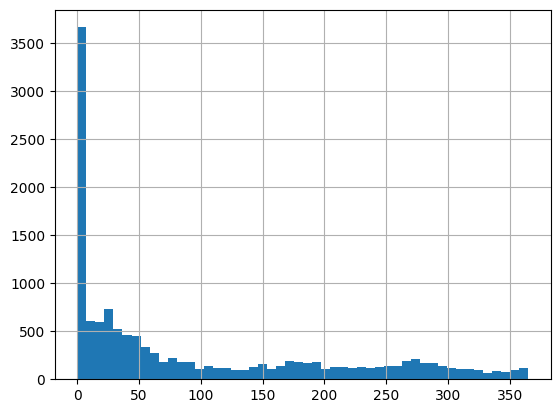

In [13]:
df_full['metastatic_diagnosis_period'].hist(bins=50)

# ✂️ Feature Selection
___________________________________________________________________________________________

In [14]:
X = df_full.drop(['patient_id', 'patient_race', 'bmi', 'breast_cancer_diagnosis_desc', 'metastatic_diagnosis_period'], axis=1)
icd = df_full.breast_cancer_diagnosis_code.str.startswith('17').astype(int)
y = df_full['metastatic_diagnosis_period']

print(X.shape, y.shape)
X.head()

(13173, 166) (13173,)


,payer_type,patient_state,patient_zip3,Region,Division,patient_age,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,Min13,Max13,Avg13,Min14,Max14,Avg14,Min15,Max15,Avg15,Min16,Max16,Avg16,Min17,Max17,Avg17,Min18,Max18,Avg18,age_group,icd_9,bmi_missing,bmi_recoded
0,COMMERCIAL,AR,724,South,West South Central,39,C50912,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,37.43,76.75,57.225000,31.67,79.59,56.607500,31.10,81.35,59.133333,35.76,82.78,61.485000,39.80,80.58,60.919167,31.71,81.69,59.132500,1,0,1,0
1,COMMERCIAL,IL,629,Midwest,East North Central,55,C50412,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.53,0.19,0.05,0.61,3.42,2.78,20.16,16.94,0.43,26.26,6.93,9.71,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.

- Encodes categorical features
- Splits data in training (80%) and testing (20%)

In [15]:
cols_categorical = X.columns[X.dtypes == 'object'].to_list()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(X[cols_categorical])
X_enc = pd.concat([
    X[X.columns[~X.columns.isin(cols_categorical)]],
    pd.DataFrame(encoder.transform(X[cols_categorical]), columns=cols_categorical)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=seed, stratify=y, test_size=.2)
print('Training size: ', X_train.shape)
print('Testing size: ', X_test.shape)

X_train.head(2)

Training size:  (10538, 166)
Testing size:  (2635, 166)


,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,Min13,Max13,Avg13,Min14,Max14,Avg14,Min15,Max15,Avg15,Min16,Max16,Avg16,Min17,Max17,Avg17,Min18,Max18,Avg18,age_group,icd_9,bmi_missing,bmi_recoded,payer_type,patient_state,Region,Division,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
928,726,75,2817.04,28.27,49.43,9.11,10.64,8.95,9.48,10.61,14.32,18.55,11.77,6.58,47.87,52.13,53.55,17.76,18.70,9.99,3.12,44.76,49426.98,2.20,2.15,7.83,9.17,7.49,11.01,14.42,16.15,15.83,10.66,3.11,13.76,26103.95,79.92,1168.35,129826.6,668.56,27.92,13.68,39.39,32.42,10.41,4.10,14.52,46.39,46.75,4.13,14.05,10.23,93.39,0.21,0.33,1.02,0.15,0.42,4.48,2.54,25.23,14.38,0.36,27.08,6.16,10.62,37.56,38.95,42.49,55.62,64.03,74.57,76.00,75.57,72.32,58.77,44.71,35.22,30.56,33.59,43.18,56.89,66.60,73.94,73.50,74.29,69.66,61.05,41.15,39.79,34.60,31.46,46.18,58.65,65.89,75.45,79.04,74.49,72.16,59.80,50.52,45.99,34.85,42.76,51.77,58.86,63.94,77.0,79.67,77.50,72.45,64.17,52.31,37.68,39.97,48.42,51.77,60.16,64.91,72.68,78.37,73.98,70.73,60.22,50.78,39.04,31.62,40.37,49.13,51.25,72.33,77.82,80.11,76.72,72.42,59.4,42.03,40.59,35.22,76.00,56.3175,30.56,74.29,55.3500,31.46,79.04,57.852500,34.85,79.67,59.413333,39.04,78.37,59.252500,31.62,80.11,57.815833,5,0,1,0,2.0,2.0,2.0,7.0,21.0,3.0
9842,907,71,28996.77,2757.96,40.64,9.87,15.30,13.14,12.18,11.46,14.15,12.52,7.14,4.23,47.63,52.37,44.47,11.39,38.24,5.89,3.46,55.71,88561.62,1.98,1.94,2.62,3.40,3.36,6.12,9.55,16.02,12.56,19.24,23.20,42.45,38429.68,56.80,9291.64,669024.6,1845.91,32.66,15.37,20.51,29.29,23.05,11.77,34.82,43.90,62.80,7.50,13.89,0.00,46.61,8.91,17.68,0.66,0.86,14.98,10.30,38.70,9.12,9.87,8.16,27.92,7.14,4.90,57.49,57.68,61.49,63.52,68.09,69.55,72.26,72.93,73.94,67.50,64.90,60.58,64.35,61.26,63.95,65.38,71.05,70.20,75.24,75.3

In [16]:
# Fit initial model
ctb_full = CatBoostRegressor(
    random_state=seed, 
    verbose=False, 
    eval_metric='RMSE'
).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

rmse(y_test, ctb_full.predict(X_test)) # 81.37 previously, now 81.38

81.38057479561728

- Recursive Feature Elimination using Shap values, directly in CatBoost.
- If you need to rerun this step, ensure `rerun_rfe = True`.

In [17]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
rerun_rfe = False
if rerun_rfe == True:
    rfe_ctb_full = ctb_full.select_features(
        X                      = X_train, 
        y                      = y_train, 
        eval_set               = (X_test, y_test), 
        features_for_select    = X_train.columns.to_list(),                         # Features that will be selected on the RFE - here, all of them
        num_features_to_select = 10,                                                # Number of features to keep from the selected
        algorithm              = EFeaturesSelectionAlgorithm.RecursiveByShapValues, # Algorithm chosen, see -> https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb 
        steps                  = 20,                                                # Number of model iterations performed in the RFE
        verbose                = False,                                             # Do not print model iterations
        train_final_model      = False,                                             # Train final model after RFE is finished 
        plot                   = True                                               # plot after the RFE is finished -> very helpful for understanding if we can get a better AUC with fewer variables
    )
    
    # Minimum loss corresponds to the lowest RMSE 
    n_todrop = np.argmin(rfe_ctb_full['loss_graph']['loss_values'])
    cols_to_keep = X.drop(rfe_ctb_full['eliminated_features_names'][:n_todrop],axis=1).columns.to_list()
    
else: 
    cols_to_keep = [
         'patient_age',
         'self_employed',
         'Average_of_Apr13',
         'Average_of_Sep13',
         'Average_of_Aug14',
         'Average_of_Aug16',
         'Average_of_May18',
         'age_group',
         'bmi_missing',
         'bmi_recoded',
         'payer_type',
         'breast_cancer_diagnosis_code',
         'metastatic_cancer_diagnosis_code',
         'icd_9'
    ]
    
X_short = X_enc[cols_to_keep]
X_train_short = X_train[cols_to_keep]
X_test_short = X_test[cols_to_keep]
# cols_categorical_short = X_train_short.columns[X_train_short.dtypes == 'category'].to_list()

print(X_short.shape)
X_short.head()

(13173, 14)


,patient_age,self_employed,Average_of_Apr13,Average_of_Sep13,Average_of_Aug14,Average_of_Aug16,Average_of_May18,age_group,bmi_missing,bmi_recoded,payer_type,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,icd_9
0,39,11.82,55.16,73.67,79.59,79.52,74.77,1,1,0,0.0,40.0,3.0,0
1,55,9.19,54.63,70.44,77.08,78.33,72.87,3,0,4,0.0,26.0,3.0,0
2,59,13.21,67.38,79.88,82.23,84.06,70.31,3,1,0,0.0,7.0,3.0,1
3,59,21.23,62.77,72.74,73.65,71.94,63.10,3,1,0,1.0,39.0,3.0,0
4,71,14.53,60.43,67.95,68.18,66.71,60.24,5,1,0,0.0,6.0,30.0,1


# ⌛ Model Training
___________________________________________________________________________________________

- This section implements 9 models on the reduced dataset from the previous step:
    - CatBoost
    - XGBoost
    - LightGBM
    - Random Forest
    - Gradient Boosting 
    - AdaBoost
    - ExtraTrees
    - LightGBM with Tweedie objective
    - KNeighbors

In [18]:
# 1. CatBoost
ctb = CatBoostRegressor(
    random_state=seed, 
    learning_rate=.02,
    verbose=False, 
    eval_metric='RMSE'
).fit(X_train_short, y_train, eval_set=(X_test_short, y_test), use_best_model=True)

rmse(y_test, ctb.predict(X_test_short))

80.8422506981281

In [19]:
# 2. XGBoost 
xgb = XGBRegressor(
    random_state=seed,
    learning_rate=.03,
    max_depth=4
).fit(X_train_short, y_train)
rmse(y_test, xgb.predict(X_test_short))

81.05553182668064

In [20]:
# 3. LightGBM
lgbm = LGBMRegressor(
    random_state=seed, 
    learning_rate=.04,
    verbose=0
).fit(X_train_short, y_train)
rmse(y_test, lgbm.predict(X_test_short))

80.94267609602487

In [21]:
# 4. Random Forest
rf = RandomForestRegressor(
    random_state=seed,
    max_depth=6
).fit(X_train_short, y_train)
rmse(y_test, rf.predict(X_test_short))

80.94581456729101

In [22]:
# 5. Gradient Boosting
gb = GradientBoostingRegressor(
    random_state=seed,
    learning_rate=.05
).fit(X_train_short, y_train)
rmse(y_test, gb.predict(X_test_short))

81.09244756686888

In [23]:
# 6. Ada Boost
ada = AdaBoostRegressor(
    random_state=seed,
    learning_rate=.0005
).fit(X_train_short, y_train)
rmse(y_test, ada.predict(X_test_short))

81.46991801551522

In [24]:
# 7. Extra Trees
et = ExtraTreesRegressor(
    random_state=seed,
    max_depth=9
).fit(X_train_short, y_train)
rmse(y_test, et.predict(X_test_short))

80.92837074742742

In [25]:
# 8. LightGBM with Tweedie objective
lgbm_tw = LGBMRegressor(
    random_state=seed,
    tweedie_variance=1.1, 
    n_estimators=40,
    verbosity=-1,
    objective="tweedie",
    metric="rmse"
).fit(X_train_short, y_train)
rmse(y_test, lgbm_tw.predict(X_test_short))

81.28279085155597

In [26]:
# 9. KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor(
    n_neighbors=39,
).fit(X_train_short, y_train)
rmse(y_test, kn.predict(X_test_short))

84.49786880177209

# 💎 Model Ensembling
___________________________________________________________________________________________

- But first, cross-validate all models :)
- Adapted version of cross-validation from https://www.kaggle.com/code/sid4ds/wids-2-00-overview-cv-setup

In [27]:
# Cross-validation for reduced model -- adapted from https://www.kaggle.com/code/sid4ds/wids-2-00-overview-cv-setup
def CV_predict(X, y, newdata, model, custom_cv, stratify_col=None, verbose=True, use_best_model=False):
    oof_preds, test_preds = {}, {}
    scores = []

    for fold, (train_ids, val_ids) in enumerate(custom_cv.split(X, stratify_col)):
        X_tr, y_tr = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        if use_best_model == True:
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                use_best_model=True,
                verbose=False)
            
        elif type(model) == XGBRegressor:
            model.fit(X_tr, y_tr, verbose=False)
            
        else: 
            model.fit(X_tr, y_tr)

        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_ids, val_preds)))
        test_preds[f'fold{fold}'] = model.predict(newdata)

        score = rmse(y_val, val_preds)
        scores.append(score)
        if verbose:
            if type(model) == CatBoostRegressor:
                print(f'Fold #{fold:>2}: {score:.5f} ({model.best_iteration_:>4} rounds)')
            else: 
                print(f'Fold #{fold:>2}: {score:.5f}')

    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mean'] = test_preds.mean(axis=1) # mean of fold-wise predictions
    
    oof_preds = pd.Series(oof_preds).sort_index()
    print(f'\nAvg score: {np.mean(scores):.5f} ± {np.std(scores):.5f}')
    print(f'OOF score: {rmse(y, oof_preds):.5f}')
    
    return oof_preds, test_preds

In [28]:
# First, cross validation
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
icd = df_full['breast_cancer_diagnosis_code'].str.startswith('17').astype(int)

# Encode categories in new data as well 
df_test_enc = pd.concat([
    df_test_full[df_test_full.columns[~df_test_full.columns.isin(cols_categorical)]],
    pd.DataFrame(encoder.transform(df_test_full[cols_categorical]), columns=cols_categorical)], axis=1)
df_test_short = df_test_enc[X_short.columns]

# 1. CatBoost
oof_preds_ctb, test_preds_ctb = CV_predict(X_short, y, df_test_short, ctb, cv, use_best_model=True, stratify_col=icd) 
# OOF score: 81.93121 -- default parameters
# OOF score: 81.88951 -- minor tunning
# OOF score: 81.78303 -- stratified

Fold # 0: 85.84405 ( 558 rounds)
Fold # 1: 81.95591 ( 585 rounds)
Fold # 2: 80.50523 ( 593 rounds)
Fold # 3: 82.51698 ( 755 rounds)
Fold # 4: 82.10064 ( 747 rounds)
Fold # 5: 84.27172 ( 629 rounds)
Fold # 6: 79.43789 ( 985 rounds)
Fold # 7: 79.09560 ( 892 rounds)
Fold # 8: 82.37732 ( 562 rounds)
Fold # 9: 79.32766 ( 768 rounds)

Avg score: 81.74330 ± 2.09942
OOF score: 81.77049


In [29]:
# 2. XGBoost
oof_preds_xgb, test_preds_xgb = CV_predict(X_short, y, df_test_short, xgb, cv, stratify_col=icd) 
# OOF score: 86.41253 -- default parameters
# OOF score: 82.21764 -- minor tunning
# OOF score: 82.13589 -- stratified

Fold # 0: 85.86543
Fold # 1: 82.42783
Fold # 2: 81.11392
Fold # 3: 82.91773
Fold # 4: 82.49398
Fold # 5: 84.56754
Fold # 6: 80.27265
Fold # 7: 79.35136
Fold # 8: 82.32991
Fold # 9: 79.78183

Avg score: 82.11222 ± 1.96190
OOF score: 82.13589


In [30]:
# 3. LightGBM
oof_preds_lgbm, test_preds_lgbm = CV_predict(X_short, y, df_test_short, lgbm, cv, stratify_col=icd) 
# OOF score: 82.62610 -- default parameters
# OOF score: 82.06666 -- minor tunning
# OOF score: 81.90552 -- stratified

Fold # 0: 85.79104
Fold # 1: 82.22551
Fold # 2: 80.78142
Fold # 3: 82.75745
Fold # 4: 82.52303
Fold # 5: 83.98426
Fold # 6: 79.64279
Fold # 7: 78.96461
Fold # 8: 82.55684
Fold # 9: 79.57234

Avg score: 81.87993 ± 2.03769
OOF score: 81.90552


In [31]:
# 4. Random Forest
oof_preds_rf, test_preds_rf = CV_predict(X_short, y, df_test_short, rf, cv, stratify_col=icd) 
# OOF score: 86.38329 -- default parameters
# OOF score: 82.12952 -- minor tunning
# OOF score: 82.00495 -- stratified

Fold # 0: 85.81512
Fold # 1: 82.01934
Fold # 2: 80.85926
Fold # 3: 82.73411
Fold # 4: 82.70045
Fold # 5: 84.32752
Fold # 6: 80.02307
Fold # 7: 79.18043
Fold # 8: 82.44575
Fold # 9: 79.68745

Avg score: 81.97925 ± 1.99259
OOF score: 82.00367


In [32]:
# 5. Gradient Boosting
oof_preds_gb, test_preds_gb = CV_predict(X_short, y, df_test_short, gb, cv, stratify_col=icd) 
# OOF score: 82.05060 -- default parameters
# OOF score: 82.11166 -- minor tunning
# OOF score: 82.04952 -- stratified

Fold # 0: 85.89877
Fold # 1: 82.28836
Fold # 2: 80.81962
Fold # 3: 82.68155
Fold # 4: 82.49444
Fold # 5: 84.54662
Fold # 6: 80.18212
Fold # 7: 79.33494
Fold # 8: 82.18845
Fold # 9: 79.82812

Avg score: 82.02630 ± 1.97545
OOF score: 82.05031


In [33]:
# 6. Ada Boost
oof_preds_ada, test_preds_ada = CV_predict(X_short, y, df_test_short, ada, cv, stratify_col=icd) 
# OOF score: 86.59601 -- default parameters
# OOF score: 82.81152 -- minor tunning
# OOF score: 82.77497 -- stratified

Fold # 0: 86.79232
Fold # 1: 82.59128
Fold # 2: 81.34617
Fold # 3: 83.90539
Fold # 4: 83.28547
Fold # 5: 85.15361
Fold # 6: 81.13998
Fold # 7: 80.04538
Fold # 8: 82.48298
Fold # 9: 80.76770

Avg score: 82.75103 ± 1.99106
OOF score: 82.77517


In [34]:
# 7. Extra Trees
oof_preds_et, test_preds_et = CV_predict(X_short, y, df_test_short, et, cv, stratify_col=icd) 
# OOF score: 87.82207 -- default parameters
# OOF score: 82.19220 -- minor tunning
# OOF score: 82.07611 -- stratified

Fold # 0: 85.73521
Fold # 1: 82.50243
Fold # 2: 80.74637
Fold # 3: 82.78403
Fold # 4: 82.56887
Fold # 5: 84.39941
Fold # 6: 80.04164
Fold # 7: 79.33789
Fold # 8: 82.74853
Fold # 9: 80.01024

Avg score: 82.08746 ± 1.94515
OOF score: 82.11071


In [35]:
# 8. LightGBM with Tweedie objective
oof_preds_lgbm_tw, test_preds_lgbm_tw = CV_predict(X_short, y, df_test_short, lgbm_tw, cv, stratify_col=icd) 

Fold # 0: 86.12803
Fold # 1: 82.20263
Fold # 2: 80.90514
Fold # 3: 82.77107
Fold # 4: 82.35903
Fold # 5: 84.46340
Fold # 6: 79.77250
Fold # 7: 78.46036
Fold # 8: 82.85428
Fold # 9: 79.59858

Avg score: 81.95150 ± 2.21441
OOF score: 81.98167


In [36]:
# 9. KNN
oof_preds_kn, test_preds_kn = CV_predict(X_short, y, df_test_short, kn, cv, stratify_col=icd) 

Fold # 0: 89.10191
Fold # 1: 85.00453
Fold # 2: 83.24484
Fold # 3: 87.01230
Fold # 4: 86.42244
Fold # 5: 86.27094
Fold # 6: 83.42023
Fold # 7: 83.35363
Fold # 8: 84.94574
Fold # 9: 83.05823

Avg score: 85.18348 ± 1.90361
OOF score: 85.20489


In [37]:
oof_preds_combined = pd.DataFrame({
    'model1': oof_preds_ctb,
    'model2': oof_preds_xgb,
    'model3': oof_preds_lgbm, 
    'model4': oof_preds_rf,
    'model5': oof_preds_gb,
    'model6': oof_preds_ada,
    'model7': oof_preds_et,
    'model8': oof_preds_lgbm_tw,
    'model9': oof_preds_kn
})

test_preds_combined = pd.DataFrame({
    'model1': test_preds_ctb['mean'],
    'model2': test_preds_xgb['mean'],
    'model3': test_preds_lgbm['mean'],
    'model4': test_preds_rf['mean'],
    'model5': test_preds_gb['mean'],
    'model6': test_preds_ada['mean'],
    'model7': test_preds_et['mean'],
    'model8': test_preds_lgbm_tw['mean'],
    'model9': test_preds_kn['mean']
})
test_preds_combined.head(3)

,model1,model2,model3,model4,model5,model6,model7,model8,model9
0,214.633858,191.921356,182.022192,188.616143,199.698555,209.316959,199.390511,199.768841,197.528205
1,74.863624,68.767578,70.219065,62.763161,68.631152,58.178533,65.064224,74.031924,62.058974
2,206.523445,213.451935,212.856831,217.002720,216.211251,217.753917,204.001378,217.871001,235.941026


In [38]:
# Check rmse
oof_preds_combined.apply(lambda x: rmse(y, x))

model1    81.770492
model2    82.135888
model3    81.905521
model4    82.003674
model5    82.050310
model6    82.775167
model7    82.110712
model8    81.981673
model9    85.204886
dtype: float64

- For ensembling, a Ridge regression is used with the coefficients estimated based on the out-of-fold predictions, after scaling

In [39]:
meta_cv = RidgeCV(
    alphas=[.001, .01, .05, .1, 1, 5, 10, 20, 50, 100],
    scoring='neg_root_mean_squared_error', 
    cv=5
)

# scaler = RobustScaler()
# oof_scaled = pd.DataFrame(scaler.fit_transform(oof_preds_combined), columns=oof_preds_combined.columns)

meta_cv.fit(oof_preds_combined, y)
print('R2 =', meta_cv.score(oof_preds_combined, y))
print('RMSE =', rmse(y, meta_cv.predict(oof_preds_combined))) 
meta_cv.coef_
# R2 = 0.43665862401010347, RMSE = 81.78540049046396
# R2 = 0.4383739431155229, RMSE = 81.6607913105591 -- stratified

R2 = 0.4383860001952856
RMSE = 81.6599147522632


array([ 0.4570215 ,  0.00457954,  0.11433347,  0.18658601,  0.11892714,
       -0.23552637,  0.06927255,  0.29775008, -0.00573222])

- Tried optuna for optimizing weights in ensemble, but it seems that Ridge outperforms it

In [40]:
# # Use optuna instead, for finding optimal weights
# import optuna

# def objective(trial):
#     y_pred = 0
# #     for column in oof_preds_combined.columns:
# #         weight = trial.suggest_uniform(column, -2, 2)
# #         y_pred += weight * oof_preds_combined[column]

#     weights = []
#     for column in oof_preds_combined.columns:
#         # Define the weights range for each variable
#         weight = trial.suggest_uniform(column, 0, 1)
#         weights.append(weight)

#     # Normalize the weights so they sum up to 1
#     weights = np.array(weights)
#     weights = weights / np.sum(np.abs(weights))

#     for weight, column in zip(weights, oof_preds_combined.columns):
#         y_pred += weight * oof_preds_combined[column]
        
#     # Calculate the RMSE
#     rmse_score = rmse(y, y_pred)

#     return rmse_score

# # Set the verbosity level to WARNING to suppress output
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Define a sampler and a pruner
# sampler = optuna.samplers.TPESampler(seed=42)
# pruner = optuna.pruners.MedianPruner()

# study = optuna.create_study(sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=100)

# # Best weights
# best_weights = np.array(list(study.best_params.values()))
# scaled_weights = best_weights / sum(best_weights)
# print('Weights:', scaled_weights)
# print('RMSE =', study.best_value)

In [41]:
# !pip install cmaes

In [42]:
# from functools import partial
# import optuna
# from optuna.samplers import RandomSampler, TPESampler

# class OptunaWeights:
#     def __init__(self, random_state, n_trials=5000):
#         self.study = None
#         self.weights = None
#         self.random_state = random_state
#         self.n_trials = n_trials

#     def _objective(self, trial, y_true, y_preds):
#         # Define the weights for the predictions from each model
#         weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds) - 1)]
#         weights.append(1 - sum(weights))  # Ensure the sum of weights is 1

#         # Calculate the weighted prediction
#         weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
#         # print((y_true < 0).sum())
#         rmsle = np.sqrt(mean_squared_error(y_true, weighted_pred))
#         return rmsle

#     def fit(self, y_true, y_preds):
#         optuna.logging.set_verbosity(optuna.logging.ERROR)
#         sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
#         pruner = optuna.pruners.HyperbandPruner()
#         self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights",
#                                          direction='minimize')
#         objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
#         self.study.optimize(objective_partial, n_trials=self.n_trials, show_progress_bar=True)
#         weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds) - 1)]
#         weights.append(1 - sum(weights))  # Ensure the sum of weights is 1
#         self.weights = weights

# ow = OptunaWeights(42)
# ow.fit(y, y_preds=np.array(oof_preds_combined.T))
# weights = ow.weights
# weights

In [43]:
# rmse(y, np.dot(weights, oof_preds_combined.T))

In [44]:
# rmse(y, [np.clip(round(i,0), a_min=0, a_max=np.inf) for i in np.dot(weights, oof_preds_combined.T)])

# 🏁 Submission
___________________________________________________________________________________________

- The final prediction is calculated using the Ridge ensembler over 8 different models

In [45]:
rmse(y, meta_cv.predict(oof_preds_combined))

81.6599147522632

In [46]:
rmse(y, pd.Series(meta_cv.predict(oof_preds_combined)).apply(lambda x: np.clip(x, a_min=0, a_max=np.inf)))

81.65990336360413

In [47]:
# Use ridge meta model
sub_ens = solution_raw.copy()
sub_ens['metastatic_diagnosis_period'] = meta_cv.predict( test_preds_combined )
sub_ens['metastatic_diagnosis_period'] = np.clip(sub_ens['metastatic_diagnosis_period'], a_min = 0, a_max = np.inf)
sub_ens.to_csv('submission.csv', index=False)
sub_ens.head() # LB = 82.833 

,patient_id,metastatic_diagnosis_period
0,730681,201.766770
1,334212,75.102389
2,571362,212.446523
3,907331,225.194920
4,208382,53.041532


<Axes: >

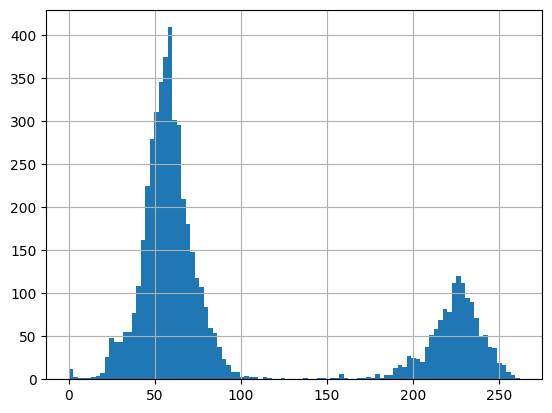

In [48]:
sub_ens['metastatic_diagnosis_period'].hist(bins=100)

In [49]:
# # Use optuna weights
# sub_w8 = solution_raw.copy()
# sub_w8['metastatic_diagnosis_period'] = np.dot(weights, test_preds_combined.T )
# sub_w8['metastatic_diagnosis_period'] = np.clip(round(sub_w8['metastatic_diagnosis_period'],0), a_min = 0, a_max = np.inf)
# sub_w8.to_csv('submission_weights.csv', index=False)
# sub_w8.head()

In [50]:
# Cross-validate ridge to use predictions
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=meta_cv.alpha_, random_state=seed)
oof_preds_final, test_preds_final = CV_predict(oof_preds_combined, y, test_preds_combined, ridge, cv, stratify_col=icd)
# Avg score: 81.84942 ± 1.61841
# Avg score: 81.68465 ± 2.11919

Fold # 0: 85.70788
Fold # 1: 81.96726
Fold # 2: 80.60634
Fold # 3: 82.39937
Fold # 4: 82.17713
Fold # 5: 84.13134
Fold # 6: 79.34690
Fold # 7: 78.80649
Fold # 8: 82.56902
Fold # 9: 79.27544

Avg score: 81.69872 ± 2.10955
OOF score: 81.72619


In [51]:
rmse(y, oof_preds_final)

81.7261914033226

In [52]:
rmse(y, oof_preds_final.apply(lambda x: np.clip(x, a_min=0, a_max=np.inf)))

81.72617730275203

In [53]:
sub_final = solution_raw.copy()
sub_final['metastatic_diagnosis_period'] = test_preds_final['mean']
sub_final['metastatic_diagnosis_period'] = sub_final['metastatic_diagnosis_period'].apply(lambda x: np.clip(x, a_min=0, a_max=np.inf))
sub_final.to_csv('submission_final_stratified.csv', index=False)
sub_final.head() # LB = 82.804 //  

,patient_id,metastatic_diagnosis_period
0,730681,201.754248
1,334212,75.099135
2,571362,212.447362
3,907331,225.201437
4,208382,53.030898


<Axes: >

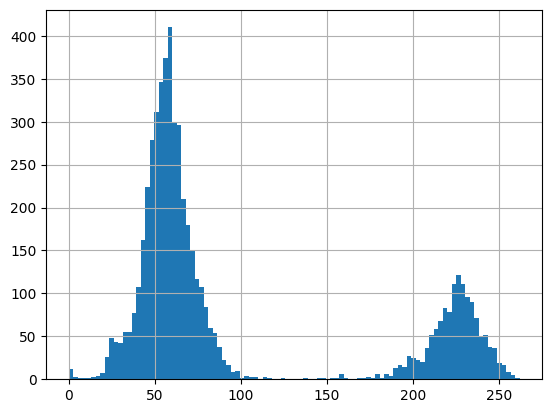

In [54]:
sub_final['metastatic_diagnosis_period'].hist(bins=100)

# 👉🏼 Next Steps
___________________________________________________________________________________________

- Creating additional features
- Experimenting with multiple cross-validation strategies
- Fine tunning models 

*Any suggestions are well received!* 😊